In [1]:
import pandas as pd
import numpy as np

In [2]:
!ls ../../data/preprocessed/atac_counts_by_sample/

check_order	     macaque_origin_peaks   mouse_origin_peaks
human_orgin_peaks    marmoset_orgin_peaks   old_quant
human_origin_peaks   marmoset_origin_peaks  primate_conserved
macaque_orgin_peaks  mouse_orgin_peaks


In [3]:
!mkdir -p ../../data/preprocessed/atac_counts_by_sample/primate_conserved/conditions

In [4]:
clusts = open('../../data/ref/cluster_list.txt', 'r').read().strip('\n').split('\n')

In [5]:
species = ['human', 'macaque', 'marmoset']

# wrangle blacklist

In [6]:
!pwd

/home/ethan/work/projects/mammalian_motor_cortex_comparative/03_atac_levels/notebooks/processing


In [7]:
for specie in species:
    peaks = '../../data/ref/blacklist_regions/{}_atac_peaks_with_four_species_ortho.bed'.format(specie)
    names = '../../data/ref/blacklist_regions/{}_peaks_that_should_be_filtered_because_of_blacklist_overlap_in_any_species.txt'.format(specie)
    bed = '../../data/ref/blacklist_regions/beds/{}_blacklist_peaks.bed'.format(specie)
    out_list = '../../data/ref/blacklist_regions/lists/{}_blacklist_peaks.txt'.format(specie)
    
    !cat $peaks | grep -wf $names > $bed
    !cut -f 1-3 $bed | sed 's/\t/-/g'  >  $out_list

# get element lists

In [8]:
origin = 'human'
use_clust = 'ASC'

In [9]:
# for origin in species:
dir_out = '../../data/preprocessed/atac_counts_by_sample/primate_conserved/ortho_elements'
!mkdir -p $dir_out
paste_string = ''
f_final = '../../data/preprocessed/atac_counts_by_sample/primate_conserved/ortho_elements/ortholog_regions.tsv'
f_filtered = '../../data/preprocessed/atac_counts_by_sample/primate_conserved/ortho_elements/ortholog_regions_filtered.tsv'.format(origin)

blacklist = '../../data/ref/blacklist_regions/lists/{}_blacklist_peaks.txt'.format(origin)

for specie in species:
    print(specie)
    f_in = '../../data/preprocessed/atac_counts_by_sample/primate_conserved/{0}/{0}_reps_{1}_atac_raw_counts_human_peaks_primate_only_ortho_filtered.tsv'.format(specie,
                                                                                                                                        use_clust)
    f_out = '../../data/preprocessed/atac_counts_by_sample/primate_conserved/ortho_elements/{}_elements.txt'.format(specie)
    !cat $f_in | cut -f1  > $f_out 
    paste_string = paste_string + f_out + ' '
!echo -e "human\tmacaque\tmarmoset" > $f_final
!paste $paste_string >> $f_final
# !cat $f_final |  grep -vf $blacklist > $f_filtered
!cp -t ../../data/ref/ $f_final
!cp -t ../../data/ref/ $f_filtered

for_ref = 'primate_sequence_ortholog_elements.tsv'
filtered_ref = 'primate_sequence_origin_ortholog_elements_blacklist_filtered.tsv'

!mv ../../data/ref/ortholog_regions.tsv ../../data/ref/ortholog_elements/$for_ref
!mv ../../data/ref/ortholog_regions_filtered.tsv ../../data/ref/ortholog_elements/$filtered_ref

human
macaque
marmoset


In [10]:
paste_string

'../../data/preprocessed/atac_counts_by_sample/primate_conserved/ortho_elements/human_elements.txt ../../data/preprocessed/atac_counts_by_sample/primate_conserved/ortho_elements/macaque_elements.txt ../../data/preprocessed/atac_counts_by_sample/primate_conserved/ortho_elements/marmoset_elements.txt '

In [11]:
def save_list(outfile, listlike):
    '''
    writes a file as a newline seperated list, useful for gsea, or storing information in general
    
    args:
        outfile : a file path to write a list of genes
        listline : an interatable object like a python list, or a numpy array
    
    '''
    return open(outfile, 'w').write(''.join([i + '\n' for i in listlike]).strip('\n'))

In [12]:
def read_list(listfile):
    '''
    reads a newline separated list like created by save_list
    args:
        listfile: path to a textfile containing a newline separated list
    returns:
        a list of strings saved in the list file
    '''
    return open(listfile, 'r').read().strip('\n').split('\n')

In [13]:
element_list = pd.read_csv( '../../data/ref/ortholog_elements/primate_sequence_ortholog_elements.tsv',
                       sep='\t')

In [15]:
def rename_index(df_, orthologs, specie, blacklist=None):
    df_use = df_.reindex(orthologs[specie])
    # use human locs to enable GREAT analysis, LDSC, ect
    df_use.index = orthologs['human']
    if blacklist:
        blacklist = read_list(blacklist)
        df_use = df_use.loc[~df_use.index.isin(blacklist)]
    return df_use

In [16]:
f_format = '../../data/preprocessed/atac_counts_by_sample/primate_conserved/{0}/{0}_reps_{1}_atac_raw_counts_human_peaks_primate_only_ortho_filtered.tsv'

In [19]:
blacklist_peaks = '../../data/ref/blacklist_regions/lists/{}_blacklist_peaks.txt'

In [24]:
element_list = pd.read_csv( 
    '../../data/ref/ortholog_elements/primate_sequence_ortholog_elements.tsv',
                       sep='\t')
blacklist = blacklist_peaks.format(origin)
!mkdir -p ../../data/processed/atac_for_edger/primate_conserved
!mkdir -p ../../data/processed/atac_for_edger/primate_conserved/conditions


for cluster in clusts: 
        sample_order = []
        dfs = []
        for specie in species:
            df = pd.read_csv(f_format.format(specie, cluster, origin),
                             header = None,
                             sep = '\t').set_index(0)
            df = df[df.columns[:-1]]
            sample_order += [specie for _ in range(df.shape[1])]
            dfs.append(rename_index(df, element_list, specie,
                                    blacklist = None)) # already blacklist filtered
        # print_specie
        out = '../../data/processed/atac_for_edger/primate_conserved/raw_counts_{}.tsv'.format( cluster)
        clust_df = pd.concat(dfs, axis=1)
        clust_df.to_csv(out, header=None, sep='\t')      
        save_list('../../data/processed/atac_for_edger/primate_conserved/conditions/sample_order_{}.txt'.format(cluster), sample_order)

In [25]:
print('done')

done


In [20]:
specie = 'human'

In [21]:
dfs = []
for cluster in clusts: 
        sample_order = []
        # for specie in species:
        df = pd.read_csv(f_format.format(specie, cluster, origin),
                         header = None,
                         sep = '\t').set_index(0)
        dfs.append(df)

In [22]:
dfs[0][4]

0
chr10-6232342-6232841      ASC_peak_10001a
chr10-6305402-6305901       ASC_peak_10011
chr10-6335981-6336480      ASC_peak_10016b
chr10-7260441-7260940       ASC_peak_10044
chr10-7275700-7276199       ASC_peak_10045
                                ...       
chr12-50763722-50764221    VLMC_peak_9904a
chr1-31101091-31101590       VLMC_peak_993
chr12-52416431-52416930     VLMC_peak_9950
chr1-31170761-31171260       VLMC_peak_996
chr12-53295230-53295729     VLMC_peak_9979
Name: 4, Length: 127052, dtype: object

In [25]:
# dfs = [i.set_index(4) for i in dfs]

In [26]:
dfs_ = [i for i in dfs if 4 in i.columns]

In [27]:
names = [name for i, name in zip(dfs, clusts) if 4 in i.columns]

In [28]:
dfs_ = [i.set_index(4) for i in dfs_]

In [29]:
dfs_ = [i.sum(axis=1).rename(name) for i, name in zip(dfs_, names)] 

In [30]:
df = pd.concat(dfs_, axis=1)

In [31]:
df

,ASC,ChC,Endo,L2_3_IT,L4_5_IT,L5_6_NP,L5_IT,L6b,L6_CT,L6_IT_CAR3,L6_IT,LAMP5,MGC,ODC,OPC,PVALB,SNCG,SST,VIP,VLMC
4,,,,,,,,,,,,,,,,,,,,
ASC_peak_10001a,152,7,0,147,45,12,23,35,56,12,52,32,29,209,34,45,12,41,28,2
ASC_peak_10011,42,2,2,27,8,0,7,3,7,2,15,8,26,43,9,8,3,7,6,0
ASC_peak_10016b,122,2,1,48,20,3,6,7,7,11,16,16,15,137,23,28,12,49,8,1
ASC_peak_10044,252,27,15,251,107,8,45,25,83,37,54,77,42,1172,22,90,19,79,35,13
ASC_peak_10045,47,6,1,66,29,1,13,8,28,27,27,10,14,44,5,47,6,43,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VLMC_peak_9904a,406,72,64,1315,371,62,201,108,357,138,257,240,218,3198,259,414,127,505,381,60
VLMC_peak_993,10,0,0,39,13,5,7,23,27,6,9,24,7,35,1,31,9,25,23,20
VLMC_peak_9950,12,14,0,56,28,3,11,9,11,11,14,17,1,38,6,18,14,11,22,17


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df_cpm = np.log2(1e6*df.div(df.sum(axis=0), axis=1)+1)

In [34]:
df_cpm.head()

,ASC,ChC,Endo,L2_3_IT,L4_5_IT,L5_6_NP,L5_IT,L6b,L6_CT,L6_IT_CAR3,L6_IT,LAMP5,MGC,ODC,OPC,PVALB,SNCG,SST,VIP,VLMC
4,,,,,,,,,,,,,,,,,,,,
ASC_peak_10001a,5.434808,3.189551,0.000000,2.790998,2.729674,3.517959,2.654024,3.790622,3.144406,2.491563,3.243446,3.230362,3.901457,3.035804,4.075860,2.874530,2.820747,2.884842,2.604556,2.448253
ASC_peak_10011,3.664008,1.731589,2.602822,1.061808,1.001033,0.000000,1.384757,1.070697,0.985701,0.824275,1.783844,1.630526,3.755013,1.311241,2.378303,1.088129,1.331315,1.063734,1.062819,0.000000
ASC_peak_10016b,5.125796,1.731589,1.822677,1.552581,1.808831,1.853539,1.251626,1.834999,0.985701,2.389166,1.850527,2.376434,3.037771,2.516087,3.552305,2.304784,2.820747,3.109753,1.293966,1.690987
ASC_peak_10044,6.150864,5.014918,5.287640,3.473807,3.847412,2.994630,3.505665,3.346304,3.658014,3.931392,3.292240,4.404392,4.405598,5.370891,3.493753,3.772655,3.406450,3.733920,2.878245,4.905643
ASC_peak_10045,3.814121,2.993276,1.822677,1.871231,2.211073,0.904029,1.997248,1.976190,2.298982,3.511430,2.432468,1.856119,2.950730,1.331134,1.736785,2.928870,2.011725,2.944441,1.183017,1.690987


<AxesSubplot:>

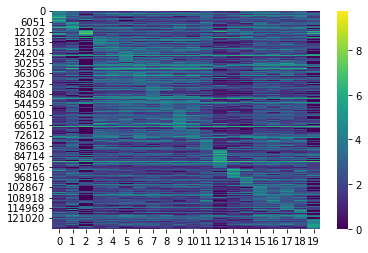

In [35]:
sns.heatmap(df_cpm.values, cmap='viridis')

In [36]:
colors = """ASC	#6FF17D
ChC	#004EE3
Endo	#60C200
L2/3 IT	#FF6FEB
L4/5 IT	#F15A98
L5 IT	#FA9E8B
L5 ET	#EE7E94
L5/6 NP	#F24799
L6 CT	#EB9863
L6 IT	#EAACD3
L6 IT CAR3	#FF7F00
L6b	#FFAC3B
LAMP5	#3E9DDF
MGC	#70AD47
OGC	#ACF068
OPC	#C3D740
PVALB	#87B9DD
SNCG	#6167E1
SST	#684CE3
VIP	#9000E3
VLMC	#9CBC00"""
colors = colors.split('\n')
colors = [i.replace(' ', '_').replace('/', '_') for i in colors]
colors = {i.split('\t')[0]: i.split('\t')[1] for i in colors}
cell_order = [i for i in colors.keys()] 

ordered_colors= [colors[i] for i in cell_order]

from matplotlib import colors as cl

In [37]:
cell_cmap = cl.ListedColormap(ordered_colors)
bounds = np.arange(len(colors) +1)
norm = cl.BoundaryNorm(bounds, cell_cmap.N)

In [38]:
clust_max = [i.split('_peak_')[0] for i in df_cpm.index]

In [39]:
def auto_heatmap(df, clust):
    np.random.seed(23)
    vals = df.values
    upper_quant= np.quantile(df, 0.99)
    lower_quant =  np.quantile(df, 0.01)
    vals[vals > upper_quant] = upper_quant
    vals[vals < lower_quant] = lower_quant
    vals = np.vstack([[(np.arange(len(clusts)) + .5)] * int(df.shape[0]/30), vals])
    clust_assign = [[cell_order.index(i) +.5] for i in clust]
    clust_assign = np.concatenate([[0]*int(df.shape[0]/30)] + clust_assign).reshape(-1, 1)
    vals = np.hstack([clust_assign, vals])
    cell_mask = np.zeros(vals.shape)
    cell_mask[0:int(df.shape[0]/30), :] = 1
    k_clust_mask = np.zeros(vals.shape)
    k_clust_mask[:, 0] = 1
    val_mask = ~(cell_mask + k_clust_mask).astype(bool)
    fig, ax = plt.subplots(figsize=(6, 7))
    # ax.imshow(vals)

    ax.imshow(np.ma.masked_where(~cell_mask.astype(bool), vals), cmap=cell_cmap,
              norm=norm, interpolation='none', aspect='auto')
    ax.imshow(np.ma.masked_where(~k_clust_mask.astype(bool), vals), cmap=cell_cmap, interpolation='none', aspect='auto')
    im = ax.imshow(np.ma.masked_where(~val_mask, vals), cmap='viridis',
                   aspect='auto', interpolation='none')
    cbar = plt.colorbar(im)
    cbar.set_label('Log2 cpm',
                       rotation=270,
                       labelpad=10) 
    # ax.set_xticks(np.arange(22), labels=['cluster'] + cell_order, rotation=90)  
    plt.show()
    # return 

In [40]:
df.shape[1]

20

In [41]:
df.columns

Index(['ASC', 'ChC', 'Endo', 'L2_3_IT', 'L4_5_IT', 'L5_6_NP', 'L5_IT', 'L6b',
       'L6_CT', 'L6_IT_CAR3', 'L6_IT', 'LAMP5', 'MGC', 'ODC', 'OPC', 'PVALB',
       'SNCG', 'SST', 'VIP', 'VLMC'],
      dtype='object')

In [42]:
np.setdiff1d(clusts, df.columns)

array(['L5_ET'], dtype='<U10')

In [43]:
auto_heatmap(df_cpm, clust_max)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 21 and the array at index 1 has size 20

In [44]:
pd.read_csv('../../

SyntaxError: unterminated string literal (detected at line 1) (3054243186.py, line 1)

In [45]:
[df.columns

SyntaxError: incomplete input (508191303.py, line 1)

In [46]:
clusts.remove('L5_ET')

In [47]:
clusts.remove('L5_ET')

ValueError: list.remove(x): x not in list